# Exploratory Data Analysis

## 0. Dataset Description
*Taken from dataset [Kaggle page](https://www.kaggle.com/competitions/asl-signs/data)*

Deaf children are often born to hearing parents who do not know sign language. Your challenge in this competition is to help identify signs made in processed videos, which will support the development of mobile apps to help teach parents sign language so they can communicate with their Deaf children.

### 0.1. Files
`train_landmark_files/[participant_id]/[sequence_id].parquet` 

The landmark data. The landmarks were extracted from raw videos with the MediaPipe holistic model. Not all of the frames necessarily had visible hands or hands that could be detected by the model.

- frame - The frame number in the raw video.
- row_id - A unique identifier for the row.
- type - The type of landmark. One of ['face', 'left_hand', 'pose', 'right_hand'].
- landmark_index - The landmark index number. Details of the hand landmark locations can be found here.
- [x/y/z] - The normalized spatial coordinates of the landmark. These are the only columns that will be provided to your submitted model for inference. The MediaPipe model is not fully trained to predict depth so you may wish to ignore the z values.

`train.csv`
- path - The path to the landmark file.
- participant_id - A unique identifier for the data contributor.
- sequence_id - A unique identifier for the landmark sequence.
- sign - The label for the landmark sequence.

## 1. Setup

In [24]:
# Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [25]:
BASE_DIR = "../input/asl-signs/"

# Read in train dataset

df = pd.read_csv(f"{BASE_DIR}/train.csv")
landmarks_path = f"{BASE_DIR}/train_landmark_files"

## 2. Dataset Information

In [26]:
df.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [27]:
df.shape

(94477, 4)

`train.csv` has 4 features: the path to each parquet file, the corresponding participant's id, the sequence id, and the sign. Contains 94477 entries.

In [28]:
df["sign"].value_counts()

sign
listen    415
look      414
shhh      411
donkey    410
mouse     408
         ... 
dance     312
person    312
beside    310
vacuum    307
zipper    299
Name: count, Length: 250, dtype: int64

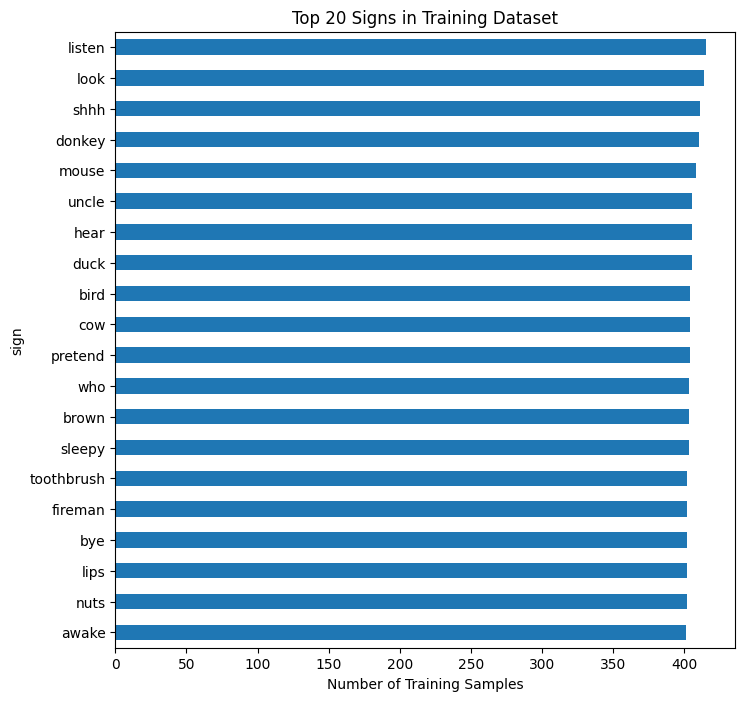

In [29]:
top_k = 20 # How many signs to plot 
fig, ax = plt.subplots(figsize=(8, 8))
df["sign"].value_counts().head(top_k).sort_values(ascending=True).plot(
    kind="barh", ax=ax, title=f"Top {top_k} Signs in Training Dataset"
)
ax.set_xlabel("Number of Training Samples")
plt.show()

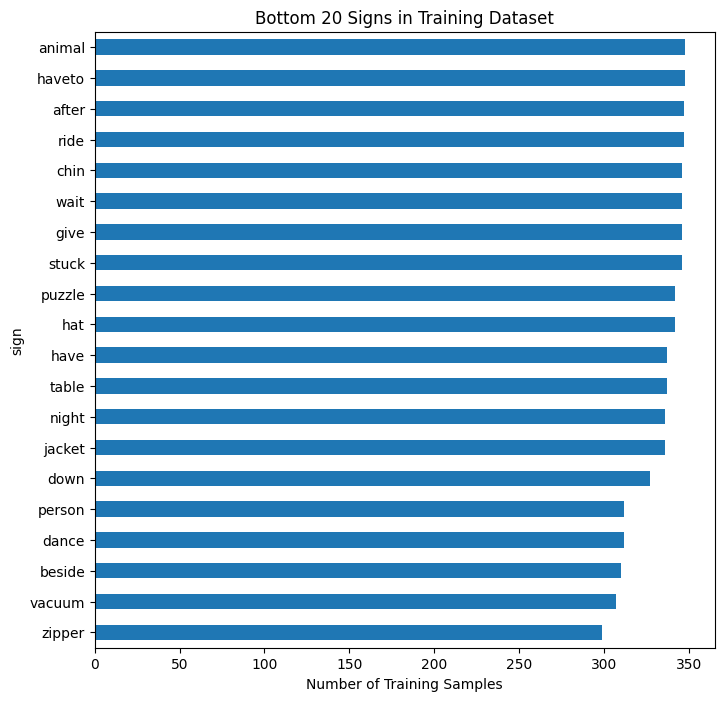

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))
df["sign"].value_counts().tail(top_k).sort_values(ascending=True).plot(
    kind="barh", ax=ax, title=f"Bottom {top_k} Signs in Training Dataset"
)
ax.set_xlabel("Number of Training Samples")
plt.show()

Recall that the Parquet files are stored in the `train_landmark_files` directory. Each entry in `train.csv` contains the path to a specific Parquet file.

In [31]:
# Get the path to a Parquet file that has the "cow" sign
target_sign = "cow"
example_parquet_path = df.query(f"sign == '{target_sign}'")["path"].values[0]
example_parquet_path

'train_landmark_files/36257/1021205595.parquet'

We can load the parquet file into a `Dataframe` to get the landmark information.

In [32]:
landmark_df = pd.read_parquet(f"{BASE_DIR}/{example_parquet_path}")
landmark_df.head()

,frame,row_id,type,landmark_index,x,y,z
0,1,1-face-0,face,0,0.476809,0.456741,-0.042842
1,1,1-face-1,face,1,0.469517,0.416260,-0.068233
2,1,1-face-2,face,2,0.471521,0.429064,-0.038716
3,1,1-face-3,face,3,0.453238,0.387312,-0.047121
4,1,1-face-4,face,4,0.467671,0.406001,-0.071225


In [33]:
example_landmark = landmark_df
unique_frames = example_landmark["frame"].nunique()
unique_types = example_landmark["type"].nunique()
types_in_video = example_landmark["type"].unique()
print(
    f"The file has {unique_frames} unique frames and {unique_types} unique types: {types_in_video}"
)

The file has 48 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']


In [34]:
landmark_df["frame"].value_counts().sort_index()

frame
1     543
2     543
3     543
4     543
5     543
6     543
7     543
8     543
9     543
10    543
11    543
12    543
13    543
14    543
15    543
16    543
17    543
18    543
19    543
20    543
21    543
22    543
23    543
24    543
25    543
26    543
27    543
28    543
29    543
30    543
31    543
32    543
33    543
34    543
35    543
36    543
37    543
38    543
39    543
40    543
41    543
42    543
43    543
44    543
45    543
46    543
47    543
48    543
Name: count, dtype: int64

## 3. Preprocessing

In [35]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score

In [36]:
def preprocess_landmarks(landmark_df, num_frames=48, feature_size=84):
    """
    Preprocess landmark DataFrame into (num_frames, features) shape.
    We'll only use left and right hands: 21 points each, (x,y), so 84 features.
    """
    # Only keep hand landmarks
    landmark_df = landmark_df[landmark_df['type'].isin(['left_hand', 'right_hand'])]

    frames = []
    for frame_id, frame_data in landmark_df.groupby('frame'):
        frame_vec = []

        for landmark_type in ['left_hand', 'right_hand']:
            type_data = frame_data[frame_data['type'] == landmark_type]
            type_data = type_data.sort_values('landmark_index')
            xy = type_data[['x', 'y']].to_numpy().flatten()

            # pad missing landmarks
            expected_landmarks = 21 * 2  # 21 points, 2 coords (x, y)
            if xy.shape[0] < expected_landmarks:
                xy = np.pad(xy, (0, expected_landmarks - xy.shape[0]))

            frame_vec.append(xy)

        frame_vec = np.concatenate(frame_vec)

        if frame_vec.shape[0] != feature_size:
            print(f"Warning: Frame has incorrect size {frame_vec.shape[0]} instead of {feature_size}")

        frames.append(frame_vec)

    frames = np.stack(frames)

    # Pad/crop to fixed number of frames
    if frames.shape[0] < num_frames:
        pad_len = num_frames - frames.shape[0]
        frames = np.pad(frames, ((0, pad_len), (0, 0)), mode='constant')
    elif frames.shape[0] > num_frames:
        frames = frames[:num_frames]

    return frames  # shape: (num_frames, features)


In [37]:
class ASLDataset(Dataset):
    def __init__(self, df, landmarks_path, label_to_index, num_frames=48):
        self.df = df
        self.landmarks_path = landmarks_path
        self.label_to_index = label_to_index
        self.num_frames = num_frames

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        participant_id = row['participant_id']
        sequence_id = row['sequence_id']
        sign = row['sign']
        
        file_path = os.path.join(self.landmarks_path, str(participant_id), f"{sequence_id}.parquet")
        
        if os.path.exists(file_path):
            landmark_df = pd.read_parquet(file_path)
            video_array = preprocess_landmarks(landmark_df, num_frames=self.num_frames)
            label = self.label_to_index[sign]
            
            return torch.tensor(video_array, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
        else:
            raise FileNotFoundError(f"Landmark file {file_path} not found.")

## 4. Model

In [38]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  
        out = self.fc(out)
        return out

## 5. Training

In [43]:
label_to_index = {label: idx for idx, label in enumerate(df['sign'].unique())}
train_dataset = ASLDataset(df, landmarks_path, label_to_index)
train_loader = DataLoader(
    train_dataset,
    batch_size=64,        
    shuffle=True,
    num_workers=4,         
    pin_memory=True        
)

In [44]:
# Initialize the GRU model
input_size = 84
hidden_size = 128
num_classes = len(label_to_index)

model = GRUModel(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GRUModel(
  (gru): GRU(84, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=250, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = torch.cuda.amp.GradScaler()

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for batch_idx, (video_data, labels) in enumerate(train_loader):
        video_data = video_data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(video_data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {epoch_accuracy:.4f}")

<ipython-input-46-5df4c2e97b3d>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch [1/10], Loss: nan, Accuracy: 0.0041
Epoch [2/10], Loss: nan, Accuracy: 0.0041
Epoch [3/10], Loss: nan, Accuracy: 0.0041
